# Notebook 03 — Data Augmentation & Regularization

**Goal:** 

Reduce overfitting and improve validation performance by adding on-the-fly data augmentation, stronger regularization, and class weights.


In [ ]:
# --- Imports & setup ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib, random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

seed = 42
np.random.seed(seed); tf.random.set_seed(seed); random.seed(seed)


data_dir = pathlib.Path("../data/raw/Winter_cereals_weeds_image_dataset")
img_height, img_width = 224, 224
batch_size = 32
validation_split = 0.2


## Load datasets
We keep the same split as in the baseline; only the model/regularization changes.


In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)


Found 10810 files belonging to 7 classes.
Using 8648 files for training.
Found 10810 files belonging to 7 classes.
Using 2162 files for validation.


## Class weights
Compute weights inversely proportional to class frequency to help minority classes.


In [ ]:
y_train = np.concatenate([y.numpy() for _, y in train_ds.unbatch().batch(1024)])
classes_idx = np.arange(num_classes)

weights = compute_class_weight(
    class_weight="balanced", classes=classes_idx, y=y_train
)
class_weights = {i: w for i, w in enumerate(weights)}
class_weights


{0: np.float64(0.8364445304188026),
 1: np.float64(2.0153810300629225),
 2: np.float64(1.7648979591836735),
 3: np.float64(1.094267999493863),
 4: np.float64(0.5525172501916688),
 5: np.float64(1.0586363079936345),
 6: np.float64(0.931695755225167)}

## Data augmentation
Use light but diverse transforms that run on the GPU.


In [4]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.10),
    layers.RandomZoom(0.10),
    layers.RandomContrast(0.10),
    layers.RandomTranslation(0.05, 0.05),
], name="augmentation")


## Model with stronger regularization
- Augmentation at the top
- Rescaling
- Convs with L2 weight decay
- Dropout increased


In [5]:
weight_decay = 1e-4

model = keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    layers.Conv2D(32, 3, padding="same", activation="relu",
                  kernel_regularizer=keras.regularizers.l2(weight_decay)),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding="same", activation="relu",
                  kernel_regularizer=keras.regularizers.l2(weight_decay)),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding="same", activation="relu",
                  kernel_regularizer=keras.regularizers.l2(weight_decay)),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation="relu",
                 kernel_regularizer=keras.regularizers.l2(weight_decay)),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


c:\Users\tim-b\Desktop\Projekte\Weed_identification\.venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Callbacks & training
Early stop on validation loss and save best model in the native Keras format.


In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("../results/models/aug_regularized_best.keras",
                                    monitor="val_loss", save_best_only=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,                 
    callbacks=callbacks,
    class_weight=class_weights, 
    verbose=1
)


Epoch 1/60
271/271 ━━━━━━━━━━━━━━━━━━━━ 157s 573ms/step - accuracy: 0.4251 - loss: 1.5847 - val_accuracy: 0.5143 - val_loss: 1.4463
Epoch 2/60
271/271 ━━━━━━━━━━━━━━━━━━━━ 140s 518ms/step - accuracy: 0.5718 - loss: 1.1726 - val_accuracy: 0.6337 - val_loss: 1.0911
Epoch 3/60
271/271 ━━━━━━━━━━━━━━━━━━━━ 143s 528ms/step - accuracy: 0.6480 - loss: 1.0190 - val_accuracy: 0.7798 - val_loss: 0.8287
Epoch 4/60
271/271 ━━━━━━━━━━━━━━━━━━━━ 139s 512ms/step - accuracy: 0.7316 - loss: 0.8794 - val_accuracy: 0.7660 - val_loss: 0.8694
Epoch 5/60
271/271 ━━━━━━━━━━━━━━━━━━━━ 143s 528ms/step - accuracy: 0.7597 - loss: 0.8199 - val_accuracy: 0.7636 - val_loss: 0.9000
Epoch 6/60
271/271 ━━━━━━━━━━━━━━━━━━━━ 149s 550ms/step - accuracy: 0.7870 - loss: 0.7494 - val_accuracy: 0.8414 - val_loss: 0.6883
Epoch 7/60
271/271 ━━━━━━━━━━━━━━━━━━━━ 147s 542ms/step - accuracy: 0.8010 - loss: 0.7444 - val_accuracy: 0.8478 - val_loss: 0.6609
Epoch 8/60
271/271 ━━━━━━━━━━━━━━━━━━━━ 148s 548ms/step - accuracy: 0.8126 -

## Learning curves


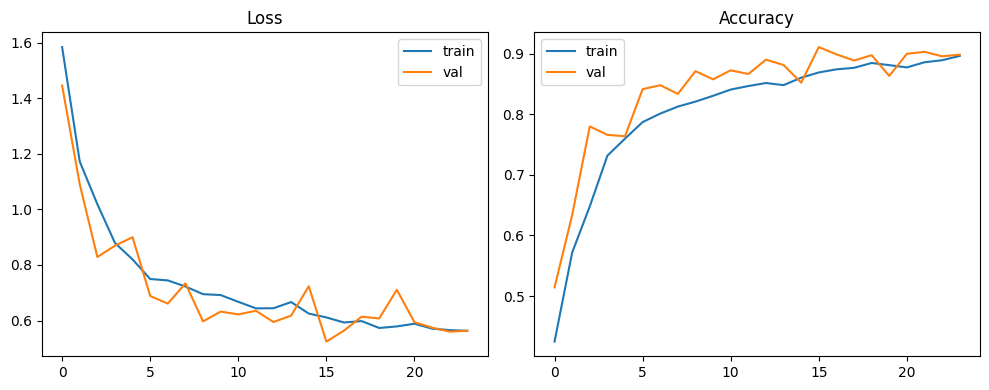

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train"); plt.plot(history.history["val_loss"], label="val")
plt.title("Loss"); plt.legend(); plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="train"); plt.plot(history.history["val_accuracy"], label="val")
plt.title("Accuracy"); plt.legend(); plt.tight_layout()

plt.savefig("../results/figures/plot_loss_accuracy_aug.png", dpi=300)
plt.show()


pd.DataFrame(history.history).to_csv("../results/logs/aug_history.csv", index=False)


**Conclusion:**  
Compared to the baseline CNN `02_baseline_cnn.ipynb`, this augmented/regularized model:  
- Generalizes better, with training and validation curves more closely aligned.  
- Achieves higher validation accuracy (~90% vs. ~85% in baseline).  
- Shows reduced overfitting thanks to augmentation and stronger regularization.  

This demonstrates that data augmentation and regularization significantly improve model robustness on unseen data.

## Validation diagnostics: confusion matrix & report


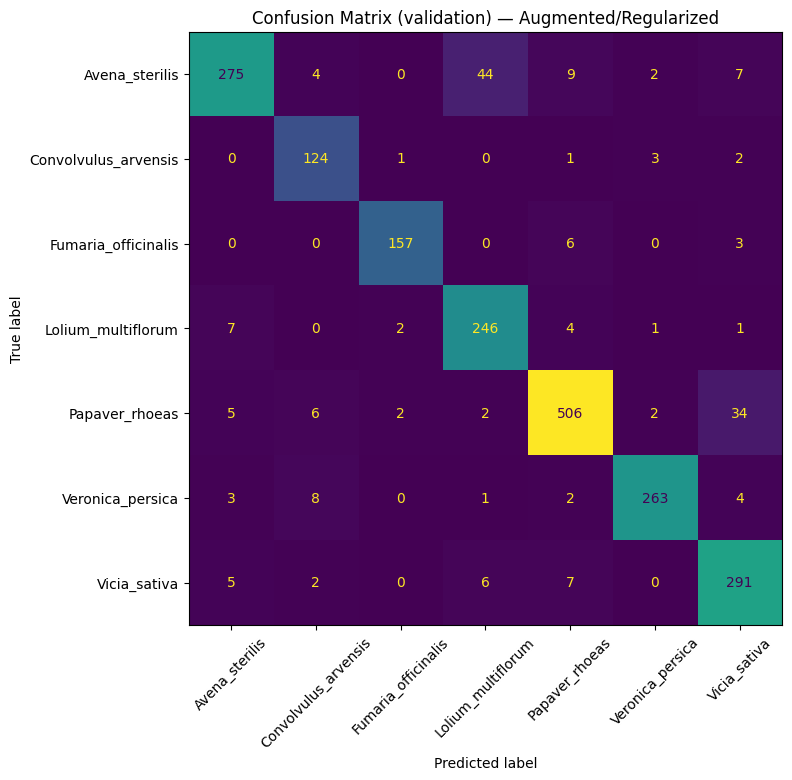

                      precision    recall  f1-score   support

      Avena_sterilis       0.93      0.81      0.86       341
Convolvulus_arvensis       0.86      0.95      0.90       131
 Fumaria_officinalis       0.97      0.95      0.96       166
  Lolium_multiflorum       0.82      0.94      0.88       261
      Papaver_rhoeas       0.95      0.91      0.93       557
    Veronica_persica       0.97      0.94      0.95       281
        Vicia_sativa       0.85      0.94      0.89       311

            accuracy                           0.91      2048
           macro avg       0.91      0.92      0.91      2048
        weighted avg       0.91      0.91      0.91      2048



In [8]:
val_images, val_labels = next(iter(val_ds.unbatch().batch(2048)))
pred = model.predict(val_images, verbose=0).argmax(axis=1)
cm = confusion_matrix(val_labels.numpy(), pred)

disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, xticks_rotation=45, colorbar=False)
plt.title("Confusion Matrix (validation) — Augmented/Regularized")
plt.tight_layout()
plt.savefig("../results/figures/confusion_matrix_aug.png", dpi=300)
plt.show()

print(classification_report(val_labels.numpy(), pred, target_names=class_names))


**Conclusion:**  
- Data augmentation + regularization significantly boosted the performance on **minority and difficult classes** (*Convolvulus_arvensis*, *Fumaria_officinalis*).  
- Overall accuracy is higher (~90%), with fewer class imbalances in predictions.  
- The main source of confusion left is between visually similar grasses (*Avena_sterilis* vs. *Lolium_multiflorum*).

## Save final model

Save the final model after all done training epochs.

In [9]:
model.save("../results/models/aug_regularized_final.keras")
